In [2]:
import numpy as np
from tracikpy import TracIKSolver
from config.config import base_link_name, end_effector_name

ee_pose = np.array([[ 0.0525767 , -0.64690764, -0.7607537 , 0.        ],
                    [-0.90099786, -0.35923817,  0.24320937, 0.2       ],
                    [-0.43062577,  0.67265031, -0.60174996, 0.4       ],
                    [ 0.        ,  0.        ,  0.        , 1.        ]])

ik_solver = TracIKSolver(
    "config/vx300s.urdf",
    base_link_name(),
    end_effector_name()
)
qout = ik_solver.ik(ee_pose)
print(qout)

[-1.54491882 -1.58614316 -0.18148161  0.03652192  2.21269505  2.30852935]


[ WARN] [1743437646.035740191]: The root link vx300s/base_link has an inertia specified in the URDF, but KDL does not support a root link with an inertia.  As a workaround, you can add an extra dummy link to your URDF.


In [4]:
qout = [ 
    -0.20862139761447906,
    -0.7439807057380676,
    1.4081944227218628,
    -0.9526020884513855,
    -0.2208932340145111,
    0.826815664768219
]


ee_out = ik_solver.fk(qout)
# ee_out
np.save("tasks/mug/ee_pose_ref.npy", ee_out)

# ee_diff = np.linalg.inv(ee_pose) @ ee_out
# trans_err = np.linalg.norm(ee_diff[:3, 3], ord=1)
# angle_err = np.arccos(np.trace(ee_diff[:3, :3] - 1) / 2)
# assert trans_err < 1e-3
# assert angle_err < 1e-3 or angle_err - np.pi < 1e-3

In [7]:
# data = np.array([
#     [-434.0253601074219, 0.0, 428.83929443359375],
#     [0.0, 433.43328857421875, 241.35557556152344],
#     [0.0, 0.0, 1.0]
# ])
# np.save("config/d405_intrinsic.npy", data)

data = np.array([
    [434.0253601074219, 0.0, 428.83929443359375],
    [0.0, 433.43328857421875, 241.35557556152344],
    [0.0, 0.0, 1.0]
])

np.save("config/d405_intrinsic_left.npy", data)

In [5]:


np.save("config/d405_intrinsic_right.npy", x)

In [4]:
import numpy as np

x = np.load("config/d405_intrinsic_right.npy")
x

array([[434.02539062,   0.        , 324.83932495],
       [  0.        , 433.43328857, 241.35557556],
       [  0.        ,   0.        ,   1.        ]])

In [2]:
k = np.array([
    [434.025390625, 0.0, 324.8393249511719],
    [0.0, 433.43328857421875, 241.35557556152344],
    [0.0, 0.0, 1.0]
])

np.save("config/d405_intrinsic_right.npy", k)

In [17]:
%pip install Pillow

from PIL import Image
import numpy as np

rgb = Image.open("tasks/mug/rgb_ref.png")
mask = Image.open("tasks/mug/mask_ref.png").convert("L")
binary_mask = mask.point(lambda p: p > 0 and 255)  # Create a binary mask
masked_rgb = np.array(rgb) * (np.array(binary_mask)[:, :, None] // 255)
masked_rgb = masked_rgb.astype(np.uint8)
masked_rgb = Image.fromarray(masked_rgb)
masked_rgb.save("tasks/mug/masked_rgb_ref.png")

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [4]:
x

array([[434.02536011,   0.        , 428.83929443],
       [  0.        , 433.43328857, 241.35557556],
       [  0.        ,   0.        ,   1.        ]])

In [6]:
from utils import rot_mat_to_euler

rot_mat_to_euler(x[:3, :3])

array([-2.03511049, -0.01081519, -1.56041638])

In [13]:
from  utils import compose_homogeneous_matrix

xyz = np.array([-0.0713569, 0.00908342, 0.0819988])
quat = np.array([0.607699, -0.596697, 0.363809, -0.377223])

mat = compose_homogeneous_matrix(xyz, quat)
np.save("config/d405_handeye_right.npy", mat)

In [14]:
mat

array([[ 0.02319098, -0.45075029,  0.89234878, -0.0713569 ],
       [-0.99969902, -0.00331056,  0.02430861,  0.00908342],
       [-0.00800294, -0.89264395, -0.4506914 ,  0.0819988 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [16]:
x

array([[ 0.01037915, -0.44768519,  0.894131  , -0.0683247 ],
       [-0.99988765, -0.01431763,  0.00443805,  0.00957573],
       [ 0.01081498, -0.89407661, -0.44778349,  0.0818357 ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

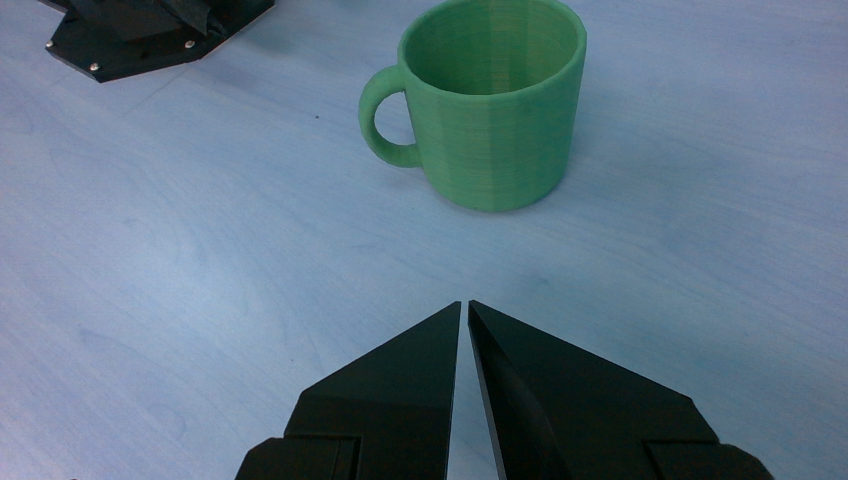

In [36]:
import h5py

with h5py.File("datasets/20250324_210108/episode_0.h5", "r") as f:
    data = f["observations/images/rgb"][:]

import PIL.Image

img = PIL.Image.fromarray(data).convert("RGB")
img

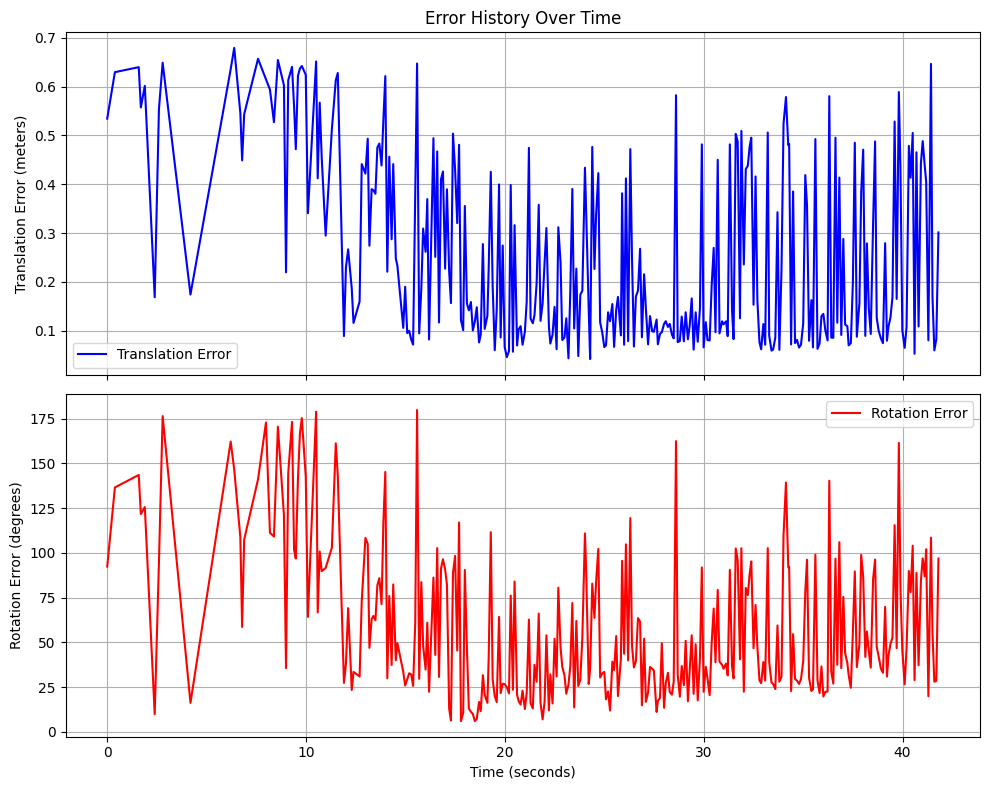

In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def plot_errors(csv_file: str) -> None:
    """
    Plot translation and rotation errors from a CSV file.

    Args:
        csv_file (str): Path to the CSV file containing error history.
    """
    # Check if the file exists
    file_path = Path(csv_file)
    if not file_path.exists():
        print(f"Error: File '{csv_file}' not found.")
        return

    # Lists to store data
    timestamps = []
    translation_errors = []
    rotation_errors = []

    # Read the CSV file
    try:
        with open(csv_file, 'r') as f:
            reader = csv.reader(f)
            header = next(reader)  # Skip header row
            if header != ["Timestamp", "Translation_Error", "Rotation_Error"]:
                print("Error: CSV file has unexpected header format.")
                return
            
            for row in reader:
                timestamp, trans_error, rot_error = map(float, row)
                timestamps.append(timestamp)
                translation_errors.append(trans_error)
                rotation_errors.append(rot_error)
    except Exception as e:
        print(f"Error reading CSV file: {e}")
        return

    if not timestamps:
        print("No data found in the CSV file.")
        return

    # Convert timestamps to relative time (seconds since start)
    start_time = timestamps[0]
    relative_times = [t - start_time for t in timestamps]

    # Create the plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Plot Translation Error
    ax1.plot(relative_times, translation_errors, 'b-', label='Translation Error')
    ax1.set_ylabel('Translation Error (meters)')
    ax1.set_title('Error History Over Time')
    ax1.grid(True)
    ax1.legend()

    # Plot Rotation Error
    ax2.plot(relative_times, rotation_errors, 'r-', label='Rotation Error')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Rotation Error (degrees)')
    ax2.grid(True)
    ax2.legend()

    # Adjust layout and display
    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    # Default CSV file path
    csv_file_path = "tmp/error_history.csv"
    plot_errors(csv_file_path)

In [3]:
plot_errors(csv_file_path)

Error: File 'tmp/error_history.csv' not found.


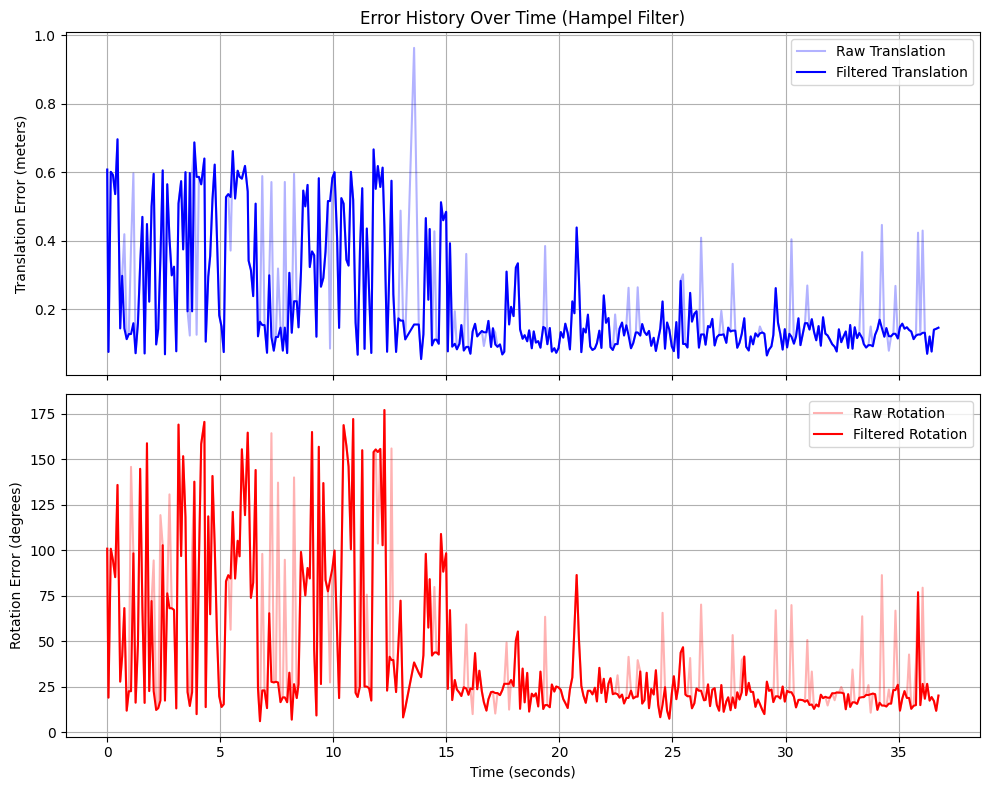

In [4]:
import csv
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

def hampel_filter(data, window_size=5, n_sigmas=3):
    """
    Apply Hampel filter to remove outliers from a 1D array.

    Args:
        data: Input array (e.g., translation_errors).
        window_size: Size of the sliding window (odd number).
        n_sigmas: Number of MADs to consider a point an outlier.

    Returns:
        Filtered array with outliers replaced by local median.
    """
    n = len(data)
    filtered = data.copy()
    half_window = window_size // 2
    
    for i in range(half_window, n - half_window):
        window = data[i - half_window:i + half_window + 1]
        median = np.median(window)
        mad = np.median(np.abs(window - median))
        if mad == 0:  # Avoid division by zero
            continue
        # Scale MAD to approximate standard deviation (1.4826 for Gaussian)
        threshold = n_sigmas * mad * 1.4826
        if np.abs(data[i] - median) > threshold:
            filtered[i] = median
    
    return filtered

def plot_errors(csv_file: str, window_size=5, n_sigmas=3) -> None:
    """
    Plot translation and rotation errors from a CSV file with Hampel filtering.

    Args:
        csv_file (str): Path to the CSV file containing error history.
        window_size (int): Size of the Hampel filter window (odd number).
        n_sigmas (float): Threshold in terms of MAD for outlier detection.
    """
    file_path = Path(csv_file)
    if not file_path.exists():
        print(f"Error: File '{csv_file}' not found.")
        return

    timestamps, translation_errors, rotation_errors = [], [], []
    with open(csv_file, 'r') as f:
        reader = csv.reader(f)
        next(reader)  # Skip header
        for row in reader:
            timestamp, trans_error, rot_error = map(float, row)
            timestamps.append(timestamp)
            translation_errors.append(trans_error)
            rotation_errors.append(rot_error)

    if not timestamps:
        print("No data found in the CSV file.")
        return

    # Convert to numpy arrays and apply Hampel filter
    translation_errors = np.array(translation_errors)
    rotation_errors = np.array(rotation_errors)
    filtered_translation = hampel_filter(translation_errors, window_size=window_size, n_sigmas=n_sigmas)
    filtered_rotation = hampel_filter(rotation_errors, window_size=window_size, n_sigmas=n_sigmas)

    # Relative time
    start_time = timestamps[0]
    relative_times = [t - start_time for t in timestamps]

    # Plot original and filtered data
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)

    # Translation Error
    ax1.plot(relative_times, translation_errors, 'b-', alpha=0.3, label='Raw Translation')
    ax1.plot(relative_times, filtered_translation, 'b-', label='Filtered Translation')
    ax1.set_ylabel('Translation Error (meters)')
    ax1.set_title('Error History Over Time (Hampel Filter)')
    ax1.grid(True)
    ax1.legend()

    # Rotation Error
    ax2.plot(relative_times, rotation_errors, 'r-', alpha=0.3, label='Raw Rotation')
    ax2.plot(relative_times, filtered_rotation, 'r-', label='Filtered Rotation')
    ax2.set_xlabel('Time (seconds)')
    ax2.set_ylabel('Rotation Error (degrees)')
    ax2.grid(True)
    ax2.legend()

    plt.tight_layout()
    plt.show()

if __name__ == '__main__':
    csv_file_path = "tmp/error_history.csv"
    plot_errors(csv_file_path, window_size=5, n_sigmas=3)

In [24]:
from PIL import Image
import numpy as np

rgb = np.array(Image.open("tasks/mug/ref_rgb.png"))
mask = np.array(Image.open("tasks/mug/ref_mask.png"))

masked_rgb = rgb.copy()
masked_rgb[mask == 0] = 0
masked_rgb = Image.fromarray(masked_rgb)
masked_rgb.save("tasks/mug/ref_rgb_masked.png")

In [13]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import os
from IPython.display import Video
import numpy as np
import matplotlib.pyplot as plt
import h5py

rgb_data = []
base_path = "datasets/20250324_211805"
episodes_1 = sorted(os.listdir(base_path))

episodes_2 = sorted([f for f in os.listdir(os.path.join(base_path)) 
                        if f.endswith('.h5')], key=lambda x: int(x.split('_')[1].split('.')[0]))

print(len(episodes_1), len(episodes_2))
# for episode in episodes_1:
#     if episode.endswith(".h5"):  # Process only .h5 files
#         h5_file = os.path.join(base_path, episode)
#         if os.path.exists(h5_file):
#             with h5py.File(h5_file, "r") as f:
#                 # rgb_data.append(f['observations/images/rgb'][:])  # Read the dataset
#                 rgb = np.array(f['/observations/images/rgb']) if '/observations/images/rgb' in f else None
#                 rgb_data.append(rgb)


# rgb_data = np.array(rgb_data)
# import cv2

# # Define the output video file name
# output_file = "output_video.mp4"

# # Get the dimensions of the frames
# height, width, _ = rgb_data[0].shape

# # Define the codec and create a VideoWriter object
# fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
# video_writer = cv2.VideoWriter(output_file, fourcc, 30, (width, height))

# # Write each frame to the video
# for frame in rgb_data:
#     video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert RGB to BGR for OpenCV

# # Release the VideoWriter
# video_writer.release()

# print(f"Video saved as {output_file}")


224 224


In [27]:
def resort_numerically(alphabetically_sorted_list):
    return sorted(alphabetically_sorted_list, key=len)

m = resort_numerically(episodes_1)
m

['episode_0.h5',
 'episode_1.h5',
 'episode_2.h5',
 'episode_3.h5',
 'episode_4.h5',
 'episode_5.h5',
 'episode_6.h5',
 'episode_7.h5',
 'episode_8.h5',
 'episode_9.h5',
 'episode_10.h5',
 'episode_11.h5',
 'episode_12.h5',
 'episode_13.h5',
 'episode_14.h5',
 'episode_15.h5',
 'episode_16.h5',
 'episode_17.h5',
 'episode_18.h5',
 'episode_19.h5',
 'episode_20.h5',
 'episode_21.h5',
 'episode_22.h5',
 'episode_23.h5',
 'episode_24.h5',
 'episode_25.h5',
 'episode_26.h5',
 'episode_27.h5',
 'episode_28.h5',
 'episode_29.h5',
 'episode_30.h5',
 'episode_31.h5',
 'episode_32.h5',
 'episode_33.h5',
 'episode_34.h5',
 'episode_35.h5',
 'episode_36.h5',
 'episode_37.h5',
 'episode_38.h5',
 'episode_39.h5',
 'episode_40.h5',
 'episode_41.h5',
 'episode_42.h5',
 'episode_43.h5',
 'episode_44.h5',
 'episode_45.h5',
 'episode_46.h5',
 'episode_47.h5',
 'episode_48.h5',
 'episode_49.h5',
 'episode_50.h5',
 'episode_51.h5',
 'episode_52.h5',
 'episode_53.h5',
 'episode_54.h5',
 'episode_55.h5',
 '

In [ ]:
psudo_list = []
for i in range(len(episodes_1)):
    psudo_name = "episode_" + str(i) + ".h5"
    psudo_list.append(psudo_name)

# Perform alphabetical sort
alphabetically_sorted_list = sorted(psudo_list)
alphabetically_sorted_list

numerically_sorted_list = sorted(psudo_list, key=lambda x: int(x.split('_')[1].split('.')[0]))
numerically_sorted_list




['episode_0.h5',
 'episode_1.h5',
 'episode_10.h5',
 'episode_100.h5',
 'episode_101.h5',
 'episode_102.h5',
 'episode_103.h5',
 'episode_104.h5',
 'episode_105.h5',
 'episode_106.h5',
 'episode_107.h5',
 'episode_108.h5',
 'episode_109.h5',
 'episode_11.h5',
 'episode_110.h5',
 'episode_111.h5',
 'episode_112.h5',
 'episode_113.h5',
 'episode_114.h5',
 'episode_115.h5',
 'episode_116.h5',
 'episode_117.h5',
 'episode_118.h5',
 'episode_119.h5',
 'episode_12.h5',
 'episode_120.h5',
 'episode_121.h5',
 'episode_122.h5',
 'episode_123.h5',
 'episode_124.h5',
 'episode_125.h5',
 'episode_126.h5',
 'episode_127.h5',
 'episode_128.h5',
 'episode_129.h5',
 'episode_13.h5',
 'episode_130.h5',
 'episode_131.h5',
 'episode_132.h5',
 'episode_133.h5',
 'episode_134.h5',
 'episode_135.h5',
 'episode_136.h5',
 'episode_137.h5',
 'episode_138.h5',
 'episode_139.h5',
 'episode_14.h5',
 'episode_140.h5',
 'episode_141.h5',
 'episode_142.h5',
 'episode_143.h5',
 'episode_144.h5',
 'episode_145.h5',
 '

In [16]:
def get_correct_indices(length):
    """
    Given the length of a list that was originally sorted alphabetically,
    returns the correct index mapping to reorder it numerically.

    Args:
        length (int): Number of elements.

    Returns:
        list: A list of indices that maps the alphabetical order to the correct numerical order.
    """
    # Generate artificial alphabetical order names (assuming they were sorted this way)
    artificial_names = [f"episode_{i}.h5" for i in range(length)]

    # Extract numerical values and store original indices
    indexed = [(i, int(name.split('_')[1].split('.')[0])) for i, name in enumerate(artificial_names)]

    # Sort by numerical values
    indexed_sorted = sorted(indexed, key=lambda x: x[1])

    # Return index mapping
    return [i[0] for i in indexed_sorted]

In [21]:
len(episodes_1)

224

In [6]:
import numpy as np
import cv2

# Load RGB image
rgb_image = cv2.imread("tasks/mug/rgb.png")  # Loads in BGR format by default
if rgb_image is not None:
    print("RGB Image Shape:", rgb_image.shape)
else:
    print("Failed to load RGB image.")

# Load Depth image
depth_image = cv2.imread("tasks/mug/depth.png", cv2.IMREAD_UNCHANGED)  # Load as grayscale or 16-bit depth
if depth_image is not None:
    print("Depth Image Shape:", depth_image.shape)
else:
    print("Failed to load Depth image.")


RGB Image Shape: (480, 640, 3)
Depth Image Shape: (480, 640)


In [ ]:
def fix_alphabetic_sort(length):
    # Generate the list of numbers from 0 to length-1
    numbers = list(range(length))
    # Convert to strings, sort alphabetically, then back to ints in correct order
    str_numbers = [str(x) for x in numbers]
    alpha_sorted = sorted(str_numbers)  # This mimics the wrong sorting
    # Create mapping from alphabetic position to correct numeric value
    result = [int(x) for x in alpha_sorted]
    # Now create the correctly sorted list
    return sorted(result)

fix_alphabetic_sort(alphebatically_episodes)

TypeError: 'list' object cannot be interpreted as an integer

In [18]:
episodes_1

['episode_0.h5',
 'episode_1.h5',
 'episode_10.h5',
 'episode_100.h5',
 'episode_101.h5',
 'episode_102.h5',
 'episode_103.h5',
 'episode_104.h5',
 'episode_105.h5',
 'episode_106.h5',
 'episode_107.h5',
 'episode_108.h5',
 'episode_109.h5',
 'episode_11.h5',
 'episode_110.h5',
 'episode_111.h5',
 'episode_112.h5',
 'episode_113.h5',
 'episode_114.h5',
 'episode_115.h5',
 'episode_116.h5',
 'episode_117.h5',
 'episode_118.h5',
 'episode_119.h5',
 'episode_12.h5',
 'episode_120.h5',
 'episode_121.h5',
 'episode_122.h5',
 'episode_123.h5',
 'episode_124.h5',
 'episode_125.h5',
 'episode_126.h5',
 'episode_127.h5',
 'episode_128.h5',
 'episode_129.h5',
 'episode_13.h5',
 'episode_130.h5',
 'episode_131.h5',
 'episode_132.h5',
 'episode_133.h5',
 'episode_134.h5',
 'episode_135.h5',
 'episode_136.h5',
 'episode_137.h5',
 'episode_138.h5',
 'episode_139.h5',
 'episode_14.h5',
 'episode_140.h5',
 'episode_141.h5',
 'episode_142.h5',
 'episode_143.h5',
 'episode_144.h5',
 'episode_145.h5',
 '

In [ ]:
def create_rgb_video(dataset_dir, folder_name, output_video_path="output_rgb_video.mp4", fps=20):
    """Create an MP4 video from RGB images in all episodes."""
    episode_files = sorted([f for f in os.listdir(os.path.join(dataset_dir, folder_name)) 
                           if f.endswith('.h5')], key=lambda x: int(x.split('_')[1].split('.')[0]))
    
    if not episode_files:
        print("No HDF5 files found in the specified folder.")
        return
    
    # Load the first episode to get image dimensions
    first_file = os.path.join(dataset_dir, folder_name, episode_files[0])
    rgb, _, _, _ = load_episode(first_file)
    if rgb is None:
        print("No RGB data found in the first episode.")
        return
    
    height, width, _ = rgb.shape
    
    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    # Process each episode
    for episode_file in episode_files:
        file_path = os.path.join(dataset_dir, folder_name, episode_file)
        rgb, _, _, _ = load_episode(file_path)
        
        if rgb is not None:
            # Convert BGR to RGB for display consistency (optional, remove if you want raw BGR)
            rgb_frame = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
            # Write frame to video
            video_writer.write(rgb_frame)
            print(f"Added frame from {episode_file}")
        else:
            print(f"Skipping {episode_file} - No RGB data found.")
    
    # Release the video writer
    video_writer.release()

In [ ]:
def create_rgb_video(dataset_dir, folder_name, output_video_path="output_rgb_video.mp4", fps=20):
    """Create an MP4 video from RGB images in all episodes."""
    episode_files = sorted([f for f in os.listdir(os.path.join(dataset_dir, folder_name)) 
                           if f.endswith('.h5')], key=lambda x: int(x.split('_')[1].split('.')[0]))
    
    if not episode_files:
        print("No HDF5 files found in the specified folder.")
        return
    
    # Load the first episode to get image dimensions
    first_file = os.path.join(dataset_dir, folder_name, episode_files[0])
    rgb, _, _, _ = load_episode(first_file)
    if rgb is None:
        print("No RGB data found in the first episode.")
        return
    
    height, width, _ = rgb.shape
    
    # Initialize video writer
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
    video_writer = cv2.VideoWriter(output_video_path, fourcc, fps, (width, height))
    
    # Process each episode
    for episode_file in episode_files:
        file_path = os.path.join(dataset_dir, folder_name, episode_file)
        rgb, _, _, _ = load_episode(file_path)
        
        if rgb is not None:
            # Convert BGR to RGB for display consistency (optional, remove if you want raw BGR)
            rgb_frame = cv2.cvtColor(rgb, cv2.COLOR_BGR2RGB)
            # Write frame to video
            video_writer.write(rgb_frame)
            print(f"Added frame from {episode_file}")
        else:
            print(f"Skipping {episode_file} - No RGB data found.")
    
    # Release the video writer
    video_writer.release()
    print(f"Video saved as {output_video_path}")

    

In [4]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import os
from IPython.display import Video
import cv2

import matplotlib.pyplot as plt

# Save the animation as an MP4 file
output_file = "output_video.mp4"

# Define the video writer
height, width, _ = rgb_data[0].shape
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Codec for MP4
video_writer = cv2.VideoWriter(output_file, fourcc, 10, (width, height))

# Write frames to the video
for frame in rgb_data:
    video_writer.write(cv2.cvtColor(frame, cv2.COLOR_RGB2BGR))  # Convert RGB to BGR for OpenCV

# Release the video writer
video_writer.release()


In [38]:
ob = np.array(rgb_data)

In [39]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import os
from IPython.display import Video

import matplotlib.pyplot as plt

# Create a figure and axis for the animation
fig, ax = plt.subplots()
im = ax.imshow(ob[0])  # Display the first frame initially
ax.axis('off')  # Turn off the axis

# Update function for the animation
def update(frame):
    im.set_array(ob[frame])
    return [im]

# Create the animation
ani = FuncAnimation(fig, update, frames=len(ob), interval=50, blit=True)

# Save the animation as an MP4 file
output_file = "output_video.mp4"
ani.save(output_file, writer="ffmpeg", fps=20)

# Close the figure to avoid displaying it twice
plt.close(fig)

# Display the video in the notebook
Video(output_file, embed=True)

In [ ]:
ob = rgb_data.copy()



[]

In [4]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import os
from IPython.display import Video

import matplotlib.pyplot as plt
import h5py

with h5py.File("datasets/20250324_203250_v2.h5", "r") as f:
    alphabetically_sorted_rgb = f['observations/images/rgb'][:]
    # sort also the joints, camera poses and etc.

psudo_list = []
for i in range(len(alphabetically_sorted_rgb)):
    psudo_name = "episode_" + str(i) + ".h5"
    psudo_list.append(psudo_name)

# Perform alphabetical sort
alphabetically_sorted_list = sorted(psudo_list)

numerically_sorted_zip = sorted(zip(alphabetically_sorted_list, alphabetically_sorted_rgb), key=lambda item: int(item[0].split('_')[1].split('.')[0]))

sorted_rgb = [item[1] for item in numerically_sorted_zip]

fig, ax = plt.subplots()
im = ax.imshow(sorted_rgb[0])
ax.axis('off') 

def update(frame):
    im.set_array(sorted_rgb[frame])
    return [im]

ani = FuncAnimation(fig, update, frames=len(sorted_rgb), interval=50, blit=True)
output_file = "output_video.mp4"
plt.close(fig)

# Display the video in the notebook
Video(output_file, embed=True)



In [38]:
print(original_indices)
print(sorted_indices)   

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221,

In [53]:
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
import os
from IPython.display import Video

import matplotlib.pyplot as plt

ob = sorted_rgb.copy()
# Create a figure and axis for the animation
fig, ax = plt.subplots()
im = ax.imshow(ob[0])  # Display the first frame initially
ax.axis('off')  # Turn off the axis

# Update function for the animation
def update(frame):
    im.set_array(ob[frame])
    return [im]

# Create the animation
ani = FuncAnimation(fig, update, frames=len(ob), interval=50, blit=True)

# Save the animation as an MP4 file
output_file = "output_video.mp4"
ani.save(output_file, writer="ffmpeg", fps=20)

# Close the figure to avoid displaying it twice
plt.close(fig)

# Display the video in the notebook
Video(output_file, embed=True)